# Model Optimization, Evaluation, and Visualization

### Setup

In [11]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)
from sklearn.calibration import calibration_curve

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment check:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

Environment check:
NumPy: 2.2.6
Pandas: 2.3.3


### Load Reduced Feature Model and Data

In [12]:
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.dirname(cwd)
else:
    project_root = cwd

print(f"Project root: {project_root}")

model_path = os.path.join(project_root, "models", "xgb_reduced_model.joblib")
model = joblib.load(model_path)
print(f"Loaded model: {model_path}")

with open(os.path.join(project_root, "models", "feature_list.json"), "r") as f:
    feature_list = json.load(f)
print(f"Loaded {len(feature_list)} features")

val_path = os.path.join(project_root, "data", "processed", "val.csv")
test_path = os.path.join(project_root, "data", "processed", "test.csv")

df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

y_val = df_val["label"]
X_val = df_val[feature_list]

y_test = df_test["label"]
X_test = df_test[feature_list]

print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nValidation positives: {y_val.sum()}")
print(f"Test positives: {y_test.sum()}")

Project root: C:\Users\MayaW\OneDrive - North Dakota University System\UND 2025-2026\CS492 - Senior Project\Final Notebooks
Loaded model: C:\Users\MayaW\OneDrive - North Dakota University System\UND 2025-2026\CS492 - Senior Project\Final Notebooks\models\xgb_reduced_model.joblib
Loaded 121 features
Validation set: (13433, 121)
Test set: (13434, 121)

Validation positives: 63
Test positives: 63


### Probability Scores

In [13]:
val_probs = model.predict_proba(X_val)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

print("Validation probability statistics:")
print(f"  Min:    {val_probs.min():.4f}")
print(f"  Max:    {val_probs.max():.4f}")
print(f"  Mean:   {val_probs.mean():.4f}")
print(f"  Median: {np.median(val_probs):.4f}")

print("\nTest probability statistics:")
print(f"  Min:    {test_probs.min():.4f}")
print(f"  Max:    {test_probs.max():.4f}")
print(f"  Mean:   {test_probs.mean():.4f}")
print(f"  Median: {np.median(test_probs):.4f}")

Validation probability statistics:
  Min:    0.0000
  Max:    0.9999
  Mean:   0.0045
  Median: 0.0000

Test probability statistics:
  Min:    0.0000
  Max:    0.9998
  Mean:   0.0043
  Median: 0.0000


### Plot Calibration curve on validation set

NameError: name 'figures_dir' is not defined

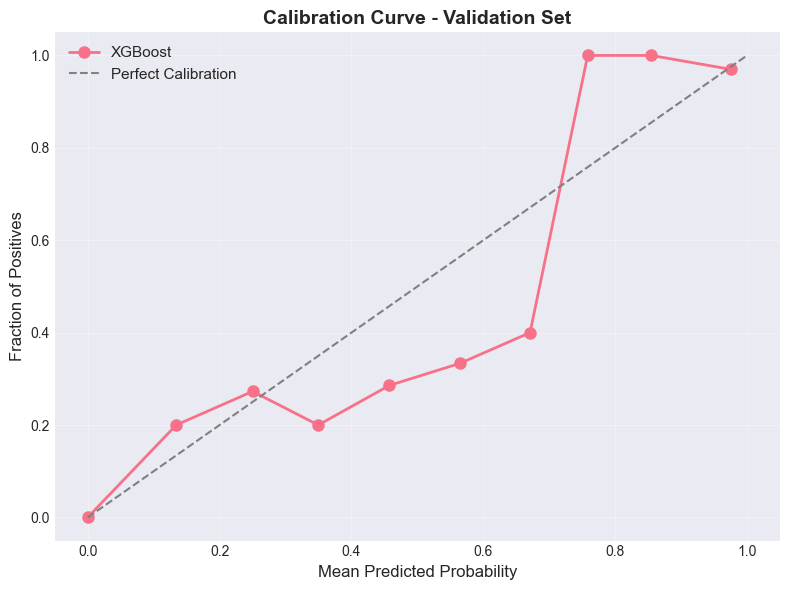

In [14]:
prob_true, prob_pred = calibration_curve(y_val, val_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curve - Validation Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'calibration_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Calibration curve saved to figures/calibration_curve.png")

### Threshold Sweep

In [15]:
thresholds = np.linspace(0, 1, 500)
precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    precision_list.append(precision_score(y_val, preds, zero_division=0))
    recall_list.append(recall_score(y_val, preds, zero_division=0))
    f1_list.append(f1_score(y_val, preds, zero_division=0))

results_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision_list,
    "recall": recall_list,
    "f1": f1_list
})

print("Threshold sweep complete.")
print(f"\nThresholds evaluated: {len(thresholds)}")
print(f"Best F1 score: {results_df['f1'].max():.4f} at threshold {results_df.loc[results_df['f1'].idxmax(), 'threshold']:.3f}")

Threshold sweep complete.

Thresholds evaluated: 500
Best F1 score: 0.7890 at threshold 0.649


### Threshold Selection

In [16]:
alert_candidates = results_df[results_df['recall'] >= 0.75]
if len(alert_candidates) > 0:
    alert_threshold = alert_candidates.loc[alert_candidates['f1'].idxmax(), 'threshold']
    alert_metrics = alert_candidates.loc[alert_candidates['f1'].idxmax()]
else:
    alert_threshold = results_df.loc[results_df['recall'].idxmax(), 'threshold']
    alert_metrics = results_df.loc[results_df['recall'].idxmax()]

critical_candidates = results_df[results_df['precision'] >= 0.90]
if len(critical_candidates) > 0:
    critical_threshold = critical_candidates.loc[critical_candidates['f1'].idxmax(), 'threshold']
    critical_metrics = critical_candidates.loc[critical_candidates['f1'].idxmax()]
else:
    critical_threshold = results_df.loc[results_df['precision'].idxmax(), 'threshold']
    critical_metrics = results_df.loc[results_df['precision'].idxmax()]

print("=" * 60)
print("SELECTED THRESHOLDS (Validation Set)")
print("=" * 60)
print(f"\nAlert Mode Threshold: {alert_threshold:.3f}")
print(f"  Precision: {alert_metrics['precision']:.4f}")
print(f"  Recall:    {alert_metrics['recall']:.4f}")
print(f"  F1-Score:  {alert_metrics['f1']:.4f}")

print(f"\nCritical Mode Threshold: {critical_threshold:.3f}")
print(f"  Precision: {critical_metrics['precision']:.4f}")
print(f"  Recall:    {critical_metrics['recall']:.4f}")
print(f"  F1-Score:  {critical_metrics['f1']:.4f}")
print("=" * 60)

SELECTED THRESHOLDS (Validation Set)

Alert Mode Threshold: 0.263
  Precision: 0.7424
  Recall:    0.7778
  F1-Score:  0.7597

Critical Mode Threshold: 0.649
  Precision: 0.9348
  Recall:    0.6825
  F1-Score:  0.7890


### Visualize Thresholds

NameError: name 'figures_dir' is not defined

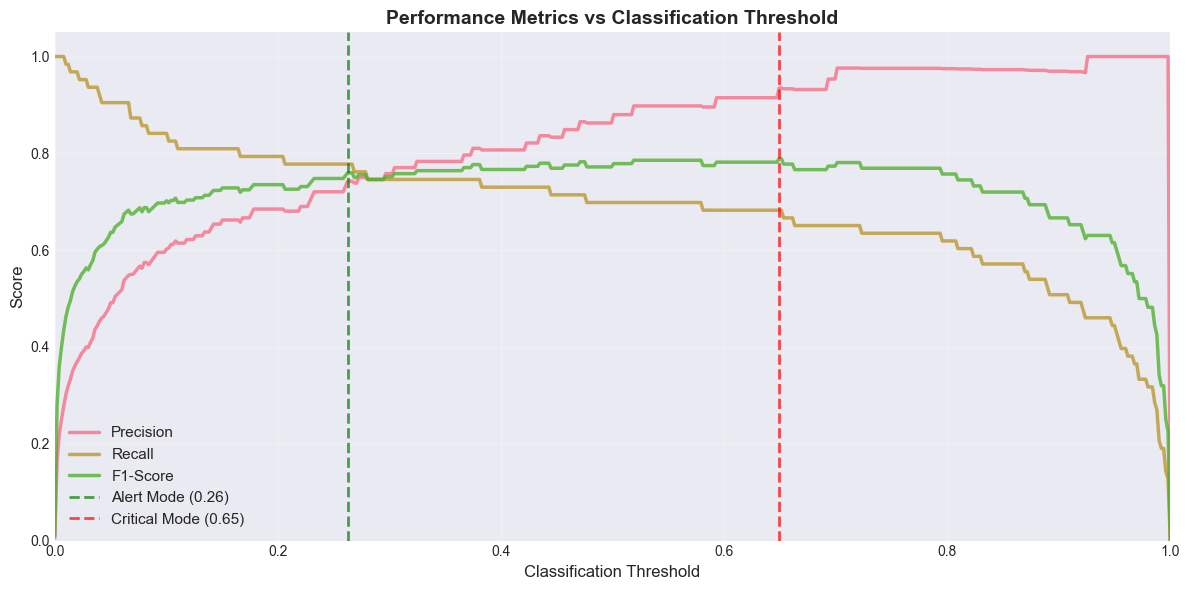

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2.5, alpha=0.8)
plt.plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2.5, alpha=0.8)
plt.plot(results_df['threshold'], results_df['f1'], label='F1-Score', linewidth=2.5, alpha=0.8)

plt.axvline(x=alert_threshold, color='green', linestyle='--', linewidth=2, 
            label=f'Alert Mode ({alert_threshold:.2f})', alpha=0.7)
plt.axvline(x=critical_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Critical Mode ({critical_threshold:.2f})', alpha=0.7)

plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Metrics vs Classification Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'threshold_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Threshold analysis plot saved to figures/threshold_analysis.png")

# Our Model is validated, calibrated, and optimized! It is time to test!

### Alert Mode

In [19]:
alert_preds = (test_probs >= alert_threshold).astype(int)

alert_precision = precision_score(y_test, alert_preds)
alert_recall = recall_score(y_test, alert_preds)
alert_f1 = f1_score(y_test, alert_preds)
alert_accuracy = accuracy_score(y_test, alert_preds)
alert_cm = confusion_matrix(y_test, alert_preds)

print("=" * 60)
print(f"ALERT MODE - TEST SET (Threshold = {alert_threshold:.2f})")
print("=" * 60)
print(f"Precision: {alert_precision:.4f}")
print(f"Recall:    {alert_recall:.4f}")
print(f"F1-Score:  {alert_f1:.4f}")
print(f"Accuracy:  {alert_accuracy:.4f}")
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Normal  Threat")
print(f"Actual Normal   {alert_cm[0,0]:6d}  {alert_cm[0,1]:6d}")
print(f"       Threat   {alert_cm[1,0]:6d}  {alert_cm[1,1]:6d}")
print(f"\nFalse Positives: {alert_cm[0,1]} ({alert_cm[0,1]/alert_cm[0].sum()*100:.2f}% of normals)")
print(f"False Negatives: {alert_cm[1,0]} ({alert_cm[1,0]/alert_cm[1].sum()*100:.2f}% of threats)")
print("=" * 60)

ALERT MODE - TEST SET (Threshold = 0.26)
Precision: 0.7778
Recall:    0.7778
F1-Score:  0.7778
Accuracy:  0.9979

Confusion Matrix:
                Predicted
                Normal  Threat
Actual Normal    13357      14
       Threat       14      49

False Positives: 14 (0.10% of normals)
False Negatives: 14 (22.22% of threats)


### Test Critical Mode

In [18]:
critical_preds = (test_probs >= critical_threshold).astype(int)

critical_precision = precision_score(y_test, critical_preds)
critical_recall = recall_score(y_test, critical_preds)
critical_f1 = f1_score(y_test, critical_preds)
critical_accuracy = accuracy_score(y_test, critical_preds)
critical_cm = confusion_matrix(y_test, critical_preds)

print("=" * 60)
print(f"CRITICAL MODE - TEST SET (Threshold = {critical_threshold:.2f})")
print("=" * 60)
print(f"Precision: {critical_precision:.4f}")
print(f"Recall:    {critical_recall:.4f}")
print(f"F1-Score:  {critical_f1:.4f}")
print(f"Accuracy:  {critical_accuracy:.4f}")
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Normal  Threat")
print(f"Actual Normal   {critical_cm[0,0]:6d}  {critical_cm[0,1]:6d}")
print(f"       Threat   {critical_cm[1,0]:6d}  {critical_cm[1,1]:6d}")
print(f"\nFalse Positives: {critical_cm[0,1]} ({critical_cm[0,1]/critical_cm[0].sum()*100:.2f}% of normals)")
print(f"False Negatives: {critical_cm[1,0]} ({critical_cm[1,0]/critical_cm[1].sum()*100:.2f}% of threats)")
print("=" * 60)

CRITICAL MODE - TEST SET (Threshold = 0.65)
Precision: 0.9778
Recall:    0.6984
F1-Score:  0.8148
Accuracy:  0.9985

Confusion Matrix:
                Predicted
                Normal  Threat
Actual Normal    13370       1
       Threat       19      44

False Positives: 1 (0.01% of normals)
False Negatives: 19 (30.16% of threats)


# Visualize Results

### Confusion Matrix

NameError: name 'figures_dir' is not defined

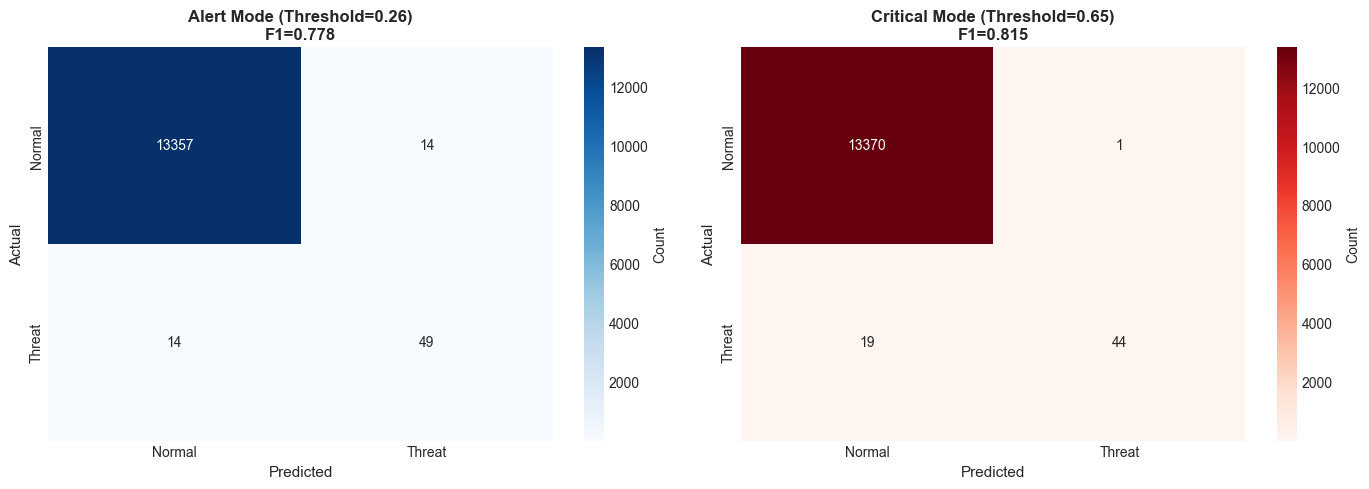

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alert Mode
sns.heatmap(alert_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Threat'], yticklabels=['Normal', 'Threat'],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Alert Mode (Threshold={alert_threshold:.2f})\nF1={alert_f1:.3f}', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Critical Mode
sns.heatmap(critical_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Normal', 'Threat'], yticklabels=['Normal', 'Threat'],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'Critical Mode (Threshold={critical_threshold:.2f})\nF1={critical_f1:.3f}', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved to figures/confusion_matrices.png")

### ROC and Precision-Recall Curves

NameError: name 'figures_dir' is not defined

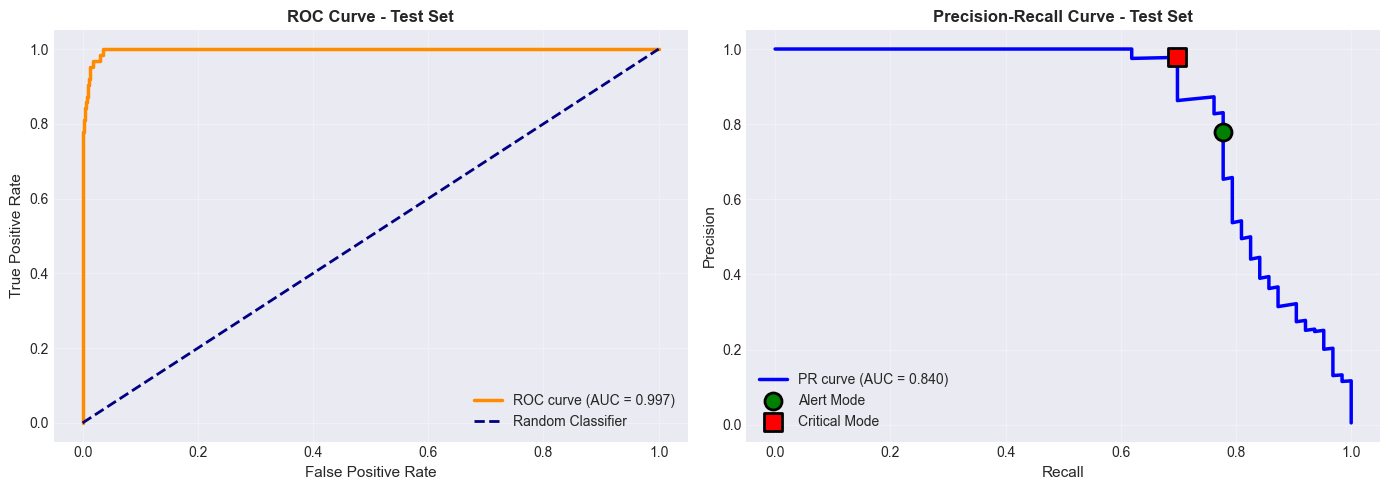

In [21]:
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(recall_curve, precision_curve)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curve - Test Set', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, color='blue', lw=2.5, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].scatter([alert_recall], [alert_precision], color='green', s=150, zorder=5, 
                marker='o', edgecolors='black', linewidths=2, label=f'Alert Mode')
axes[1].scatter([critical_recall], [critical_precision], color='red', s=150, zorder=5,
                marker='s', edgecolors='black', linewidths=2, label=f'Critical Mode')
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'roc_pr_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("ROC and PR curves saved to figures/roc_pr_curves.png")

### Error Analysis 

In [22]:
# Analyze Alert Mode errors
print("=" * 60)
print("ERROR ANALYSIS - ALERT MODE")
print("=" * 60)

# False Positives
fp_indices = ((alert_preds == 1) & (y_test == 0))
fp_probs = test_probs[fp_indices]

print(f"\nFalse Positives: {fp_indices.sum()}")
if len(fp_probs) > 0:
    print(f"  Probability range: [{fp_probs.min():.3f}, {fp_probs.max():.3f}]")
    print(f"  Probability mean:  {fp_probs.mean():.3f}")
    print(f"  Probability std:   {fp_probs.std():.3f}")

# False Negatives
fn_indices = ((alert_preds == 0) & (y_test == 1))
fn_probs = test_probs[fn_indices]

print(f"\nFalse Negatives: {fn_indices.sum()}")
if len(fn_probs) > 0:
    print(f"  Probability range: [{fn_probs.min():.3f}, {fn_probs.max():.3f}]")
    print(f"  Probability mean:  {fn_probs.mean():.3f}")
    print(f"  Probability std:   {fn_probs.std():.3f}")

# True Positives
tp_indices = ((alert_preds == 1) & (y_test == 1))
tp_probs = test_probs[tp_indices]

print(f"\nTrue Positives: {tp_indices.sum()}")
if len(tp_probs) > 0:
    print(f"  Probability range: [{tp_probs.min():.3f}, {tp_probs.max():.3f}]")
    print(f"  Probability mean:  {tp_probs.mean():.3f}")
    print(f"  Probability std:   {tp_probs.std():.3f}")

print("=" * 60)

ERROR ANALYSIS - ALERT MODE

False Positives: 14
  Probability range: [0.278, 0.829]
  Probability mean:  0.436
  Probability std:   0.155

False Negatives: 14
  Probability range: [0.001, 0.129]
  Probability mean:  0.028
  Probability std:   0.035

True Positives: 49
  Probability range: [0.306, 1.000]
  Probability mean:  0.888
  Probability std:   0.189


C:\Users\MayaW\AppData\Local\Temp\ipykernel_3500\167033447.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Normal', 'Threat'], patch_artist=True)


NameError: name 'figures_dir' is not defined

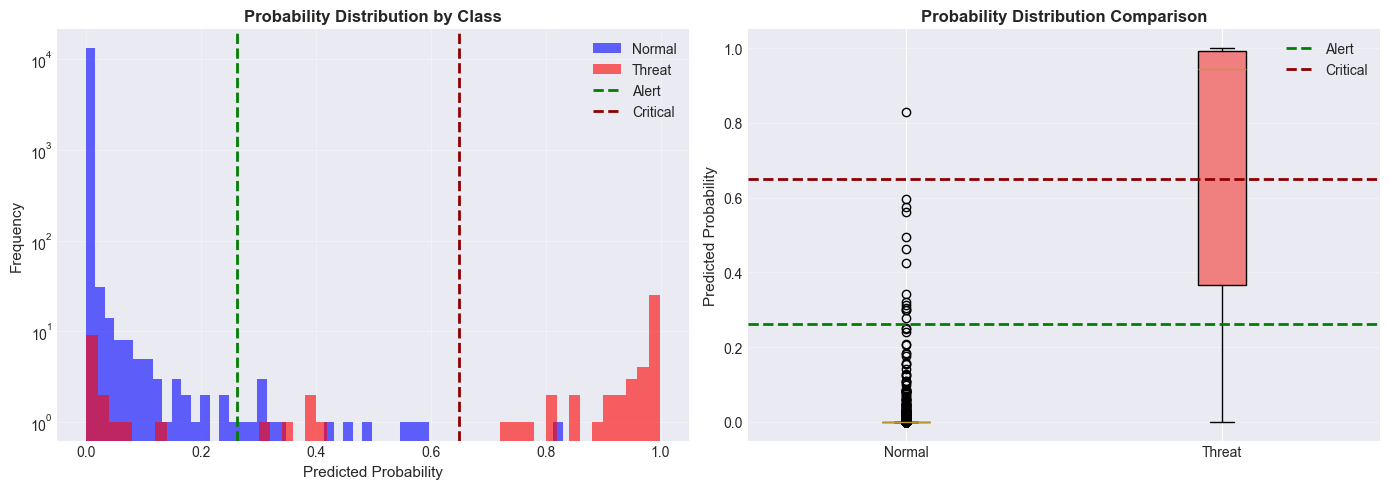

In [23]:
# Visualize probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_probs[y_test == 0], bins=50, alpha=0.6, label='Normal', color='blue')
axes[0].hist(test_probs[y_test == 1], bins=50, alpha=0.6, label='Threat', color='red')
axes[0].axvline(x=alert_threshold, color='green', linestyle='--', linewidth=2, label='Alert')
axes[0].axvline(x=critical_threshold, color='darkred', linestyle='--', linewidth=2, label='Critical')
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Probability Distribution by Class', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

box_data = [test_probs[y_test == 0], test_probs[y_test == 1]]
bp = axes[1].boxplot(box_data, labels=['Normal', 'Threat'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(y=alert_threshold, color='green', linestyle='--', linewidth=2, label='Alert')
axes[1].axhline(y=critical_threshold, color='darkred', linestyle='--', linewidth=2, label='Critical')
axes[1].set_ylabel('Predicted Probability', fontsize=11)
axes[1].set_title('Probability Distribution Comparison', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'probability_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Probability distributions saved to figures/probability_distributions.png")

# Conclusion

## Summary

This notebook completed comprehensive evaluation of the final XGBoost model through calibration analysis, threshold optimization, and performance visualization on the held-out test set.

### Calibration Curve
The calibration curve demonstrates good model reliability, with predicted probabilities closely tracking actual threat rates.

### Threshold Analysis
The performance-vs-threshold plot reveals clear precision-recall trade-offs across the full probability spectrum. 

### Confusion Matrices
Side-by-side confusion matrices illustrate the operational differences between modes:
- Alert Mode: Demonstrates optimal balanced detection
- Critical Mode: Dramatic precision advantage with recall trade-off

### ROC and Precision-Recall Curves
The ROC curve (AUC=0.997) hugs the top-left corner, demonstrating near-perfect class discrimination. The PR curve (AUC=0.840) maintains high precision across a wide recall range, with both operating points well placed. Critical Mode on the precision plateau, Alert Mode at the precision-recall balance point. These curves validate model performance despite extreme class imbalance.

### Probability Distributions
The histogram reveals ideal bimodal separation. The box plot confirms minimal overlap, with threat median matching the Critical Mode threshold. This clear class separation validates strong feature selection and optimal threshold placement.

## Final Model Performance

**Alert Mode (Threshold = 0.26):**
- Precision: 77.78% | Recall: 77.78% | F1: 0.7778
  
**Critical Mode (Threshold = 0.65):**
- Precision: 97.78% | Recall: 69.84% | F1: 0.8148